In [2]:
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from pathlib import Path

def smooth_layered_array(layers, smooth_width=20, method="cubic"):
    """
    Create a layered 1D array with smooth transitions between layers.
    
    Parameters
    ----------
    layers : list of tuples (value, n_points)
    smooth_width : int, width of smoothing (number of points)
    method : str, "linear", "cubic", or "gaussian"
    
    Returns
    -------
    m : 1D numpy array
    """
    # create layered array
    m = np.concatenate([np.full(n, val) for val, n in layers])
    
    if method == "linear":
        for i in range(1, len(layers)):
            start = sum(n for _, n in layers[:i]) - smooth_width
            end = sum(n for _, n in layers[:i]) + smooth_width
            ramp = np.linspace(layers[i-1][0], layers[i][0], end-start)
            m[start:end] = ramp
    elif method == "cubic":
        # smooth with a simple cubic interpolation using convolution
        x = np.arange(len(m))
        # replace jumps with linear interpolation first
        jumps = np.where(np.diff(m) != 0)[0]
        for j in jumps:
            idx = np.arange(j-smooth_width//2, j+smooth_width//2)
            idx = idx[(idx >= 0) & (idx < len(m))]
            ramp = np.linspace(m[j], m[j+1], len(idx))
            m[idx] = ramp
    elif method == "gaussian":
        # smooth entire array using Gaussian filter
        m = gaussian_filter1d(m, sigma=smooth_width)
    
    return m


def smooth_average(m, window_size=5):
    """
    Smooth a 1D gradient array using a Gaussian filter.

    Parameters
    ----------
    grad : ndarray
        Input gradient array.
    sigma : float
        Standard deviation of the Gaussian kernel. Larger values produce smoother gradients.

    Returns
    -------
    grad_smooth : ndarray
        Smoothed gradient array of the same length as grad.
    """
    kernel = np.ones(window_size) / window_size
    return np.convolve(m, kernel, mode='same')  # 'same' keeps original length



# Directories in WSL
PROJECT_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/Project'
IMAGE_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/image'
DATA_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/data'


# Directories in Windows
PROJECT_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/Project'
DATA_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/data'
IMAGE_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/image'



In [ ]:
plt.plot(t, src)

t_min, t_max = np.argmin(src), np.argmax(src)
t_0_idx = np.argmin(np.abs(src[t_min:t_max])) + t_min
plt.axvline(t[t_0])

In [66]:
f_0 = 7e3

wavelength = 3500 / f_0
wavelength

0.5

In [62]:
vs_1

3798.9602216175017

167.0


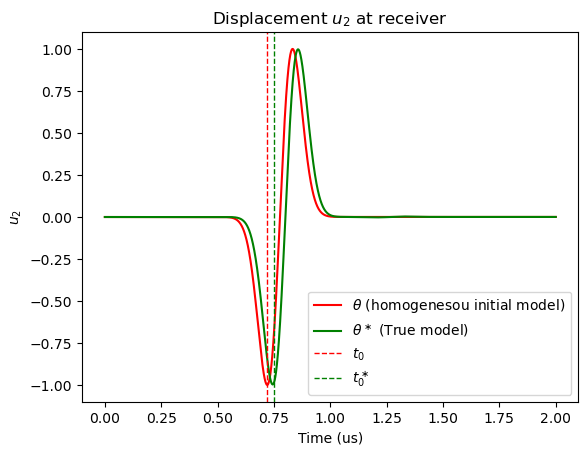

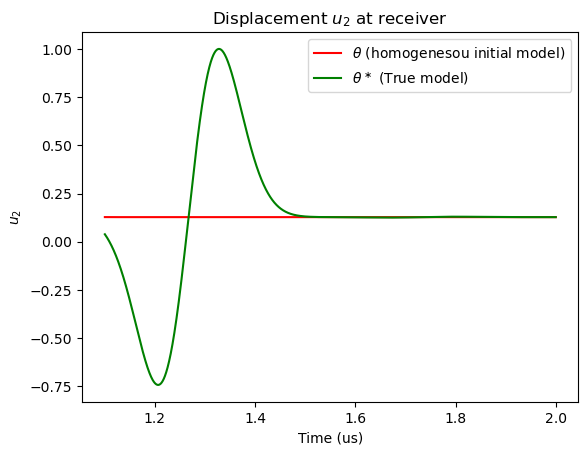

$\chi$=1420.5207293069016


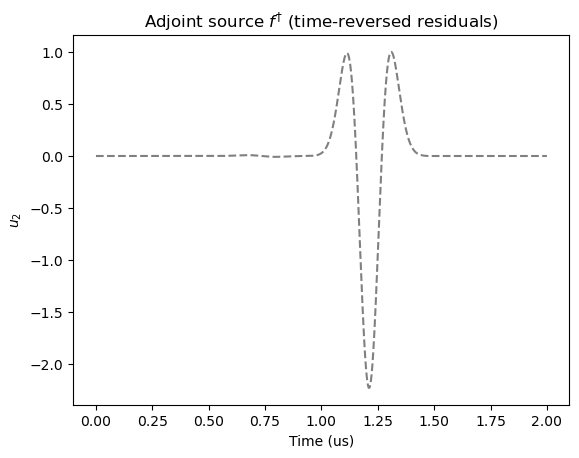

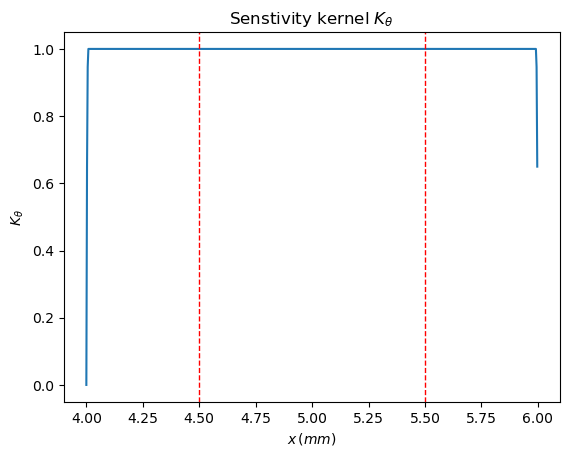

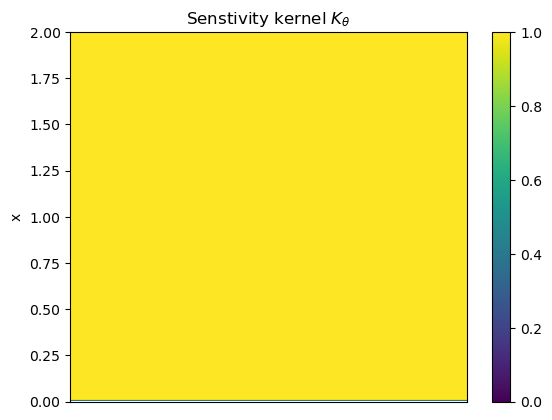

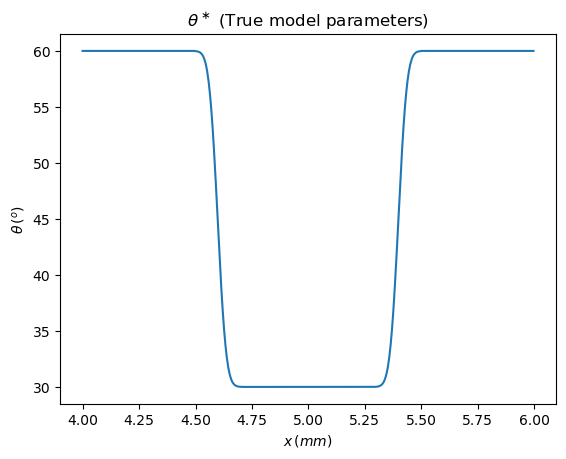

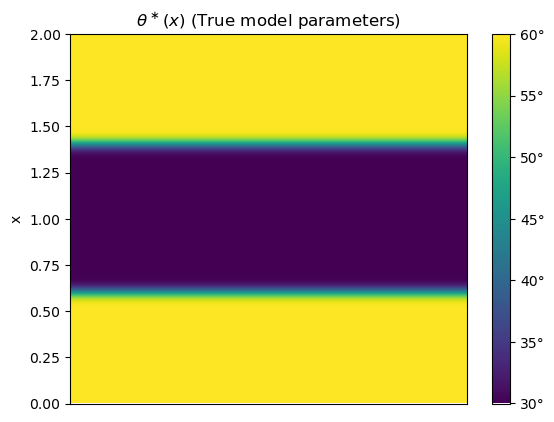

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from material_ela_constants.Elastic_Material import Austenite



f_0 = 4e3
f_c = 2e4

# ---- Grid & time setup ----
space = 10
reference_v = 3000        # m/s (typical for solids)
N_p = 50       # points per wavelength
dz = reference_v / (f_c * N_p)
nz = int(round(space / dz))
z = np.linspace(0, space, nz+1)


time = 10e-4 * 2
dt = 1/(f_c*200)
nt = int(round(time / dt))

t = np.linspace(0, time, nt+1)


# ---- Medium ----
matl = Austenite()
theta_1 = np.pi/3 
theta_2 = np.pi/6

theta_deg = np.ones(nz) * theta_1



RHO = matl.RHO


C44_1 = matl.rotated_parameters(theta_1)['c44']
C44_2 = matl.rotated_parameters(theta_2)['c44']
vs_1 = np.sqrt(C44_1/RHO)
vs_2 = np.sqrt(C44_2/RHO)

rho = np.ones(nz) * RHO
src_mag = 1e3


# ---- Source ----
def ricker(t, f0): 
    t0 = 1/f0
    return (1 - 2*(np.pi*f0*(t - t0))**2) * np.exp(-(np.pi*f0*(t - t0))**2)


def orientated_C44(theta_deg):
    C44 = matl.C44 + np.sin(theta_deg) ** 2 * (matl.C66 - matl.C44)

    return C44





src = ricker(t, f_0) * src_mag



import numpy as np


def simulate_sh_wave(theta_deg, m, m_lim, src, src_idx, rec_indices, rho, dz, dt, field='u'):
    """ 
    1D SH wave propagation using flux-form finite differences with variable C44.
    Free-surface (stress-free) boundaries at z=0 and z=L.

    Parameters
    ----------
    C44 : ndarray
        Stiffness array of length nz.
    src : ndarray
        Source time function of length nt.
    src_idx : int
        Index of the source location.
    rec_indices : list[int]
        Indices of receiver locations.
    rho : ndarray
        Density array of length nz.
    dz : float
        Spatial step (m)
    dt : float
        Time step (s)
    field : str
        'u' for displacement, 'dudz' for spatial derivative

    Returns
    -------
    records : ndarray
        Receiver time series (len(rec_indices), nt)
    fullfield : ndarray, optional
        Full wavefield (nz, nt) if requested
    """
    nz = len(theta_deg)
    nt = len(src)
    C = orientated_C44(theta_deg).copy()
    C[m_lim[0]:m_lim[1]] = orientated_C44(m) 
    
    # Initialize fields
    u = np.zeros(nz)
    u_old = np.zeros_like(u)
    u_new = np.zeros_like(u)
    
    # Receivers
    records = np.zeros((len(rec_indices), nt))
    
    # Full field storage
    if field in ['u', 'dudz']:
        fullfield = np.zeros((nz, nt))
    
    # Time stepping
    for it in range(nt):
        # Flux form for variable C44
        C_plus  = 0.5 * (C + np.roll(C, -1))
        C_minus = 0.5 * (C + np.roll(C, 1))

        # Central difference for interior points
        dCdu_dx2 = np.zeros(nz)
        # Interior: i = 1 .. nz-2
        dCdu_dx2[1:-1] = (C_plus[1:-1]*(u[2:] - u[1:-1]) - C_minus[1:-1]*(u[1:-1] - u[:-2])) / dz**2
        # Free-surface boundaries: stress = 0 => derivative = 0
        dCdu_dx2[0] = (C_plus[0]*(u[1] - u[0])) / dz**2
        dCdu_dx2[-1] = (-C_minus[-1]*(u[-1] - u[-2])) / dz**2

        # Time update (second-order)
        u_new[:] = 2*u - u_old + dt**2 * (dCdu_dx2 / rho)

        # Apply Ricker source (spread over a few nodes)
        nodes = np.arange(max(0, src_idx-2), min(nz, src_idx+3))
        weights = np.exp(-0.5*((nodes-src_idx)/1.0)**2)
        weights /= np.sum(weights)
        u_new[nodes] += src[it] * weights / (rho[nodes]*dz)

        # Shift time levels
        u_old[:] = u
        u[:] = u_new

        # Record receivers
        for i, idx in enumerate(rec_indices):
            records[i, it] = u[idx]

        # Store full field if requested
        if field == 'u':
            fullfield[:, it] = u
        elif field == 'dudz':
            # Interior: central difference
            fullfield[1:-1, it] = (u[2:] - u[:-2]) / (2*dz)
            # Boundaries: one-sided second-order
            fullfield[0, it] = (-3*u[0] + 4*u[1] - u[2]) / (2*dz)
            fullfield[-1, it] = (3*u[-1] - 4*u[-2] + u[-3]) / (2*dz)

    if field in ['u', 'dudz']:
        return records, fullfield
    else:
        return records






# C44 = np.ones(nz) * C44_1

# margin_gap = 200

# m_lim = (src_id+margin_gap, rec_id-margin_gap)


src_loc = 4
src_id = np.argmin(np.abs(z - src_loc))

rec_loc = 6
rec_id = np.argmin(np.abs(z - rec_loc))

C44 = np.ones(nz) * C44_1

# layer size
layer_size = 1
layer_nz = int(layer_size/dz)
layer_margin_ratio = 0.1
layer_margin_edge = int(layer_margin_ratio * layer_nz)
layer_main = layer_nz - 2 * layer_margin_edge 





print((rec_id - src_id - layer_nz) / 2)

if (rec_id - src_id - layer_nz) % 2 == 0: 
    margin_gap = (int(round((rec_id - src_id - layer_nz) / 2)), int(round((rec_id - src_id - layer_nz) / 2)))
else:
    margin_gap = (int(round((rec_id - src_id - layer_nz) / 2)), int(round((rec_id - src_id - layer_nz) / 2))-1)
m_lim = (src_id+margin_gap[0], rec_id-margin_gap[1])




m = [theta_1]* (m_lim[1]-m_lim[0])

records_homo, wavefiled_homo  = simulate_sh_wave(theta_deg, m, m_lim,src, src_idx=src_id, rec_indices=[rec_id], dz=dz, dt=dt, rho=rho, field='dudz')



t_max = np.argmax(src)
t_min = np.argmin(src[:t_max])
t_0 = t[np.argmin(np.abs(src[t_min:t_max])) + t_min]


src_t_max = t[np.argmax(src)]
t_first_homo = (rec_loc - src_loc) / vs_1 + t_0

plt.plot(t*1e3, records_homo[0] / records_homo[0].max(), color='red', label=r'$\theta$ (homogenesou initial model)')


# true model 
layers = [(theta_1, layer_margin_edge), (theta_2, layer_main), (theta_1, layer_margin_edge)]
m_true = smooth_layered_array(layers, smooth_width=10, method="gaussian")



records_true = simulate_sh_wave(theta_deg, m_true, m_lim, src, src_idx=src_id, rec_indices=[rec_id], dz=dz, dt=dt, rho=rho, field=False)
t_first_true = (rec_loc - src_loc - layer_size) / vs_1 + layer_size/vs_2 + t_0



plt.plot(t*1e3, records_true[0] / records_homo[0].max(), color='green', label=r'$\theta^\ast$ (True model)')

plt.axvline(x=t_first_homo*1e3, color='red', linestyle='--', linewidth=1, label=r'$t_0$')
plt.axvline(x=t_first_true*1e3, color='green', linestyle='--', linewidth=1, label=r'$t^\ast_0$')


plt.xlabel("Time (us)")
plt.ylabel(r"$u_2$")
plt.title(r"Displacement $u_2$ at receiver")
plt.legend()
# plt.grid(True)
# plt.tight_layout()
plt.savefig(Path(IMAGE_DIR_WIN, fr'oberseved_data.png'))

plt.show()






t_first_coda = (rec_loc - src_loc - layer_size) / vs_1 + 3*layer_size/vs_2 + t_0

t_0__idx_coda = np.argmin(np.abs(t - 1.1e-3))

plt.plot(t[t_0__idx_coda:]*1e3, records_homo[0][t_0__idx_coda:] / records_true[0][t_0__idx_coda:].max(), color='red', label=r'$\theta$ (homogenesou initial model)')

plt.plot(t[t_0__idx_coda:]*1e3, records_true[0][t_0__idx_coda:] / records_true[0][t_0__idx_coda:].max(), color='green', label=r'$\theta^\ast$ (True model)')


# plt.axvline(x=t_first_coda*1e3, color='gray', linestyle='--', linewidth=1, label=r'$t^\ast_2$')

plt.xlabel("Time (us)")
plt.ylabel(r"$u_2$")
plt.title(r"Displacement $u_2$ at receiver")
plt.legend()
# plt.grid(True)
# plt.tight_layout()
plt.savefig(Path(IMAGE_DIR_WIN, fr'coda_data.png'))
plt.show()



def cal_mistif_src_adj(u, u_obs):
     
    res = u_obs - u
    misfit = 0.5 * np.sum(res**2) * dt
    src_adj = np.flip(res)
    
    return misfit, src_adj

mistif, src_adj = cal_mistif_src_adj(records_homo[0],records_true[0])

print(fr"$\chi$={mistif}")

m = [theta_1]* (m_lim[1]-m_lim[0])



_, wavefiled_adjoint = simulate_sh_wave(theta_deg, m, m_lim, src_adj, src_idx=rec_id, rec_indices=[src_id], dz=dz, dt=dt, rho=rho, field='dudz')

plt.plot(t*1e3, src_adj / src_adj.max(), label=f'residuals', color='gray', linestyle='--')
plt.xlabel("Time (us)")
plt.ylabel(r"$u_2$")
plt.title(r'Adjoint source $f^\dag$ (time-reversed residuals)')
plt.savefig(Path(IMAGE_DIR_WIN, fr'adjoint_source.png'))

plt.show()


theta_true = np.ones(nz) * theta_1
theta_true[m_lim[0]:m_lim[1]] = m_true





def compute_grad(filed_forward, field_adj, m, m_lim):
    K_c44 = np.sum(np.flip(field_adj[m_lim[0]:m_lim[1],:], axis=1) * filed_forward[m_lim[0]:m_lim[1],:], axis=1) * dt
    d_C44_d_theta = np.sin(2*m) * (matl.C66 - matl.C44)
    return K_c44 * d_C44_d_theta

m_lim_show = (src_id, rec_id)
m = theta_deg[m_lim_show[0]:m_lim_show[1]]
K_theta = compute_grad(wavefiled_homo, wavefiled_adjoint, m, m_lim_show)


# plt.plot(z[m_lim_show[0]:m_lim_show[1]], K_c44/ K_c44[m_lim[0]-m_lim_show[0]:m_lim[1]-m_lim_show[0]].max())
# plt.axvline(x=z[m_lim[0]], color='r', linestyle='--', linewidth=1)
# plt.axvline(x=z[m_lim[1]], color='r', linestyle='--', linewidth=1)
# plt.ylabel(r'$K_C44$')
# plt.xlabel(r'$x$')

# plt.title(r"Senstivity kernel $K_{C44}$")
# plt.savefig(Path(IMAGE_DIR_WIN, fr'senstivity_kernel.png'))

# plt.show()



plt.plot(z[m_lim_show[0]:m_lim_show[1]], K_theta / K_theta[m_lim[0]-m_lim_show[0]:m_lim[1]-m_lim_show[0]].max())
plt.axvline(x=z[m_lim[0]], color='r', linestyle='--', linewidth=1)
plt.axvline(x=z[m_lim[1]], color='r', linestyle='--', linewidth=1)
plt.ylabel(r'$K_\theta$')
plt.xlabel(r'$x\,(mm)$')

plt.title(r"Senstivity kernel $K_{\theta}$")
plt.savefig(Path(IMAGE_DIR_WIN, fr'senstivity_kernel.png'))

plt.show()

import matplotlib.ticker as mticker

x = z[m_lim_show[0]:m_lim_show[1]] - src_loc

f = K_theta / K_theta[m_lim[0]-m_lim_show[0]:m_lim[1]-m_lim_show[0]].max()
y = np.linspace(0, 1, 100)

F = np.tile(f, (len(y), 1))  # shape (ny, nx)

# Flip x-y by transposing F
F_flip = F.T  # now shape (nx, ny)

im =plt.imshow(F_flip, extent=[y.min(), y.max(), x.min(), x.max()],
           aspect='auto', origin='lower', cmap='viridis')
# plt.xlabel("y")
plt.ylabel("x")
plt.xticks([])
plt.ylim(0, 2)

plt.title(r"Senstivity kernel $K_{\theta}$")

# cbar = plt.colorbar(im, label=r'$K_\theta$')
cbar = plt.colorbar(im)

# cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
plt.savefig(Path(IMAGE_DIR_WIN, fr'senstivity_kernel_plane.png'))
plt.show()


plt.plot(z[m_lim_show[0]:m_lim_show[1]], theta_true[m_lim_show[0]:m_lim_show[1]] /np.pi * 180)
plt.xlabel(r'$x\,(mm)$')
plt.ylabel(r'$\theta \, (^o)$')

plt.title(r"$\theta^\ast$ (True model parameters)")
plt.savefig(Path(IMAGE_DIR_WIN, fr'True_model_parameters.png'))

plt.show()




# Extend into 2D by repeating along y
x = z[m_lim_show[0]:m_lim_show[1]] - src_loc


f = theta_true[m_lim_show[0]:m_lim_show[1]]/(np.pi) * 180
y = np.linspace(0, 1, 100)

F = np.tile(f, (len(y), 1))  # shape (ny, nx)

# Flip x-y by transposing F
F_flip = F.T  # now shape (nx, ny)

im =plt.imshow(F_flip, extent=[y.min(), y.max(), x.min(), x.max()],
           aspect='auto', origin='lower', cmap='viridis')
# plt.xlabel("y")
plt.ylabel("x")
plt.xticks([])
plt.ylim(0, 2)
# cbar = plt.colorbar(im, label=r'$\theta^\ast$')
cbar = plt.colorbar(im)

plt.title(r"$\theta^\ast(x)$ (True model parameters)")

cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
plt.savefig(Path(IMAGE_DIR_WIN, fr'True_model_parameters_plane.png'))






In [297]:
f_0 = 12e3
src = ricker(t, f_0) * src_mag

def objective(m_flat):
    m = m_flat.reshape(-1)
    # --- Forward simulation ---
    records, wave_forward = simulate_sh_wave(theta_deg, m, m_lim,
                                             src, src_idx=src_id, rec_indices=[rec_id],
                                             dz=dz, dt=dt, rho=rho, field='dudz')

    # Misfit and adjoint source
    misfit, src_adj = cal_mistif_src_adj(records[0], records_true[0])

    # Adjoint simulation
    _, wave_adj = simulate_sh_wave(theta_deg, m, m_lim,
                                   src_adj, src_idx=rec_id, rec_indices=[src_id],
                                   dz=dz, dt=dt, rho=rho, field='dudz')

    # Gradient
    K_theta = compute_grad(wave_forward, wave_adj, m, m_lim)
    K_theta /= np.abs(K_theta).max()
    K_theta = smooth_average(K_theta, 5)
    grad = np.clip(K_theta, -1e3, 1e3)

    return misfit, grad.ravel()




m0 = m_history[-1]
# m0 = np.array([theta_1] * (m_lim[1] - m_lim[0]))

# m_history = [m0.copy()]
# misfit, _ = objective(m0)
# misfit_history = [misfit]


In [299]:
from scipy.optimize import minimize


def store_history(mk):
    m_history.append(mk.copy())          # store current model
    misfit, _ = objective(mk)            # compute misfit from objective
    misfit_history.append(misfit)        # store misfit

result = minimize(objective, m0, method='L-BFGS-B', jac=True, callback=store_history,
                  options={'maxiter': 10, 'ftol': 1e-12, 'gtol': 1e-8, 'maxls': 20})






In [300]:
len(m_history)

41

In [ ]:
np.save(Path(IMAGE_DIR_WIN, fr'model_history_f0_{f_0}.npy'), m_history)
np.save(Path(IMAGE_DIR_WIN, fr'misfit_history_f0_{f_0}.npy'), misfit_history)


11

In [ ]:
def plot_plane_orientation(x, f):

    y = np.linspace(0, 1, 100)

    F = np.tile(f, (len(y), 1))  # shape (ny, nx)

    # Flip x-y by transposing F
    F_flip = F.T  # now shape (nx, ny)

    im =plt.imshow(F_flip, extent=[y.min(), y.max(), x.min(), x.max()],
            aspect='auto', origin='lower', cmap='viridis', vmin=30, vmax=60)
    # plt.xlabel("y")
    plt.ylabel("x")
    plt.xticks([])

    # cbar = plt.colorbar(im, label=r'$\theta$')

    # cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
    return None


# t_points = [1e-4, 3e-4, 5e-4, 7e-4]


# import matplotlib.ticker as mticker




# for t_point in t_points:
#     t_idx = np.argmin(np.abs(t - t_point))

#     forward_field = wavefiled_homo[:,t_idx]
#     adjoint_field = wavefiled_adjoint[:,t_idx]
#     plt.figure()
#     x = z[m_lim_show[0]:m_lim_show[1]]

#     f = forward_field[m_lim_show[0]:m_lim_show[1]] / forward_field[m_lim_show[0]:m_lim_show[1]].max()
#     y = np.linspace(0, 1, 100)

#     F = np.tile(f, (len(y), 1))  # shape (ny, nx)

#     # Flip x-y by transposing F
#     F_flip = F.T  # now shape (nx, ny)

#     im =plt.imshow(F_flip, extent=[y.min(), y.max(), x.min(), x.max()],
#             aspect='auto', origin='lower', cmap='viridis')
#     # plt.xlabel("y")
#     plt.ylabel("x")
#     plt.xticks([])
#     plt.title(r"Forward field $\nabla u$")

#     cbar = plt.colorbar(im)
#     # cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
#     # plt.savefig(Path(IMAGE_DIR_WIN, fr'senstivity_kernel_plane.png'))
#     plt.show()
#     plt.figure()
#     f = adjoint_field[m_lim_show[0]:m_lim_show[1]] / np.abs(adjoint_field[m_lim_show[0]:m_lim_show[1]]).max()
#     y = np.linspace(0, 1, 100)

#     F = np.tile(f, (len(y), 1))  # shape (ny, nx)

#     # Flip x-y by transposing F
#     F_flip = F.T  # now shape (nx, ny)

#     im =plt.imshow(F_flip, extent=[y.min(), y.max(), x.min(), x.max()],
#             aspect='auto', origin='lower', cmap='viridis')
#     # plt.xlabel("y")
#     plt.ylabel("x")
#     plt.xticks([])
#     plt.title(r"Adjoint field $\nabla u&\dag$")

#     cbar = plt.colorbar(im)




In [ ]:
# Initial guess
learning_rate = 0.1  # initial guess
n_steps = 20
misfit_history = []
m_history = []



m = np.array([theta_1] * (m_lim[1] - m_lim[0]))

for i in range(n_steps):
    # --- Forward simulation ---
    records, wave_forward = simulate_sh_wave(C44, m, m_lim,
                                             src, src_idx=src_id, rec_indices=[rec_id],
                                             dz=dz, dt=dt, rho=rho, field='dudz')

    # Misfit and adjoint source
    misfit, src_adj = cal_mistif_src_adj(records[0], records_true[0])
    misfit_history.append(misfit)
    m_history.append(m.copy())

    # Adjoint simulation
    _, wave_adj = simulate_sh_wave(C44, m, m_lim,
                                   src_adj, src_idx=rec_id, rec_indices=[src_id],
                                   dz=dz, dt=dt, rho=rho, field='dudz')

    # Gradient
    grad = compute_grad(wave_forward, wave_adj, m, m_lim)

    grad_norm = np.linalg.norm(grad)
    print(f"Iter {i}: misfit = {misfit:.4e}, ||grad|| = {grad_norm:.4e}")
    grad = grad / np.abs(grad).max()
    grad = smooth_grad_gaussian(grad)
    # --- Backtracking line search ---
    alpha = learning_rate
    rho_ls = 0.2  # step size reduction factor
    misfit_new = misfit + 1  # initialize higher than current misfit
    max_ls_steps = 5
    for ls_step in range(max_ls_steps):
        m_trial = m - alpha * grad
        # forward simulation with trial model
        records_trial, _ = simulate_sh_wave(C44, m_trial, m_lim,
                                            src, src_idx=src_id, rec_indices=[rec_id],
                                            dz=dz, dt=dt, rho=rho, field='dudz')
        misfit_trial, _ = cal_mistif_src_adj(records_trial[0], records_true[0])
        if misfit_trial < misfit:  # sufficient decrease
            misfit_new = misfit_trial
            m = m_trial
            break
        else:
            alpha *= rho_ls  # reduce step size

    if misfit_new >= misfit:
        print("Line search failed, using last m")
    
    # Optionally, plot gradient
    plt.plot(range(m_lim[1] - m_lim[0]), grad)
    plt.show()
    
    
    
    


In [ ]:
id = 8
theta_est = theta_true.copy()
theta_est[m_lim[0]:m_lim[1]] = m_history[id]

plt.plot(np.arange(m_lim_show[0], m_lim_show[1]), theta_true[m_lim_show[0]:m_lim_show[1]] / np.pi * 180)

plt.plot(np.arange(m_lim_show[0], m_lim_show[1]), theta_est[m_lim_show[0]:m_lim_show[1]]/ np.pi * 180)


plt.legend([ fr'$m^*$', r'$m^{(j)}$',])
plt.xlabel(r'$N_z$')
plt.savefig(Path(IMAGE_DIR_WIN, fr'model_id_{id}.png'))

plt.show()



In [ ]:
def plot_plane_orientation(x, f):

    y = np.linspace(0, 1, 100)

    F = np.tile(f, (len(y), 1))  # shape (ny, nx)

    # Flip x-y by transposing F
    F_flip = F.T  # now shape (nx, ny)

    im =plt.imshow(F_flip, extent=[y.min(), y.max(), x.min(), x.max()],
            aspect='auto', origin='lower', cmap='viridis', vmin=30, vmax=60)
    # plt.xlabel("y")
    plt.ylabel("x")
    plt.xticks([])

    # cbar = plt.colorbar(im, label=r'$\theta$')

    # cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
    return None


id = 4
theta_est = theta_true.copy()
theta_est[m_lim[0]:m_lim[1]] = m_history[id]

plot_plane_orientation(z[m_lim[0]:m_lim[1]], theta_est[m_lim_show[0]:m_lim_show[1]] / np.pi * 180)
plt.savefig(Path(IMAGE_DIR_WIN, fr'model_id_{id}.png'))
plt.show()
plot_plane_orientation(z[m_lim[0]:m_lim[1]], theta_true[m_lim_show[0]:m_lim_show[1]] / np.pi * 180)
cbar = plt.colorbar(im, label=r'$\theta$')

cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
# plt.savefig(Path(IMAGE_DIR_WIN, fr'model_true.png'))
plt.show()

# plot_plane_orientation(z[m_lim[0]:m_lim[1]], (theta_true[m_lim_show[0]:m_lim_show[1]] -  theta_est[m_lim_show[0]:m_lim_show[1]])/ np.pi * 180)
# plt.show()

In [ ]:
from scipy.optimize import minimize

def objective(m_flat):
    m = m_flat.reshape(-1)
    # --- Forward simulation ---
    records, wave_forward = simulate_sh_wave(C44, m, m_lim,
                                             src, src_idx=src_id, rec_indices=[rec_id],
                                             dz=dz, dt=dt, rho=rho, field='dudz')

    # Misfit and adjoint source
    misfit, src_adj = cal_mistif_src_adj(records[0], records_true[0])

    # Adjoint simulation
    _, wave_adj = simulate_sh_wave(C44, m, m_lim,
                                   src_adj, src_idx=rec_id, rec_indices=[src_id],
                                   dz=dz, dt=dt, rho=rho, field='dudz')

    # Gradient
    K_c44 = compute_grad(wave_forward, wave_adj, m_lim)
    d_C44_d_theta = np.sin(2*m) * (matl.C66 - matl.C44)
    grad = K_c44 * d_C44_d_theta
    grad /= np.abs(grad).max() + 1e-12
    grad = np.clip(grad, -1e3, 1e3)

    return misfit, grad.ravel()

def store_history(mk):
    m_history.append(mk.copy())          # store current model
    misfit, _ = objective(mk)            # compute misfit from objective
    misfit_history.append(misfit)        # store misfit

m0 = np.array([theta_1] * (m_lim[1] - m_lim[0]))
result = minimize(objective, m0, method='L-BFGS-B', jac=True, callback=store_history,
                  options={'maxiter': 10, 'ftol': 1e-12, 'gtol': 1e-8, 'maxls': 20})


np.save(Path(IMAGE_DIR_WIN, fr'model_history_f0_{f_0}.npy'), m_history)
np.save(Path(IMAGE_DIR_WIN, fr'misfit_history_f0_{f_0}.npy'), misfit_history)



In [ ]:
id
theta_est = theta_true.copy()
theta_est[m_lim[0]:m_lim[1]] =result.x
plt.plot(np.arange(m_lim_show[0], m_lim_show[1]), theta_true[m_lim_show[0]:m_lim_show[1]] / np.pi * 180)

plt.plot(np.arange(m_lim_show[0], m_lim_show[1]), theta_est[m_lim_show[0]:m_lim_show[1]]/ np.pi * 180)


plt.legend([ fr'$m^*$', r'$m^{(j)}$',])
plt.xlabel(r'$N_z$')
plt.savefig(Path(IMAGE_DIR_WIN, fr'model_id_{id}.png'))

plt.show()

In [ ]:
np.save(Path(IMAGE_DIR_WIN, fr'model_history_f0_{f_0}.npy'), m_history)
np.save(Path(IMAGE_DIR_WIN, fr'misfit_history_f0_{f_0}.npy'), misfit_history)


In [227]:
m_history.append(m_history[37])
misfit_history.append(misfit_history[37])

In [15]:
misfit_history = np.load(Path(IMAGE_DIR_WIN, fr'misfit_history_circle_skipping.npy'))
m_history = np.load(Path(IMAGE_DIR_WIN, fr'model_history_circle_skipping.npy'))
max_ite = len(misfit_history) 

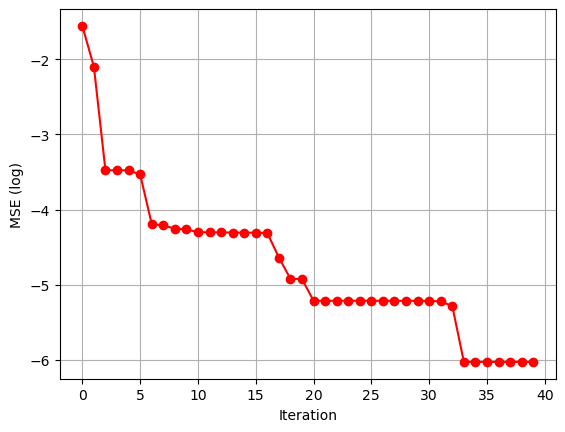

In [31]:

mse = [np.mean((theta_true[m_lim[0]:m_lim[1]] - m_history[id])**2) for id in range(max_ite)]
plt.plot(range(max_ite), np.log(mse), marker='o', linestyle='-', color='red')
plt.xlabel('Iteration')
plt.ylabel(r'MSE (log)')

# Set x-axis ticks from 0 to 10
# plt.xticks(range(max_ite))  # 0,1,2,...,10

plt.grid(True)

plt.savefig(Path(IMAGE_DIR_WIN, fr'MSE.png'))

plt.show()

In [255]:
del m_history[40:]

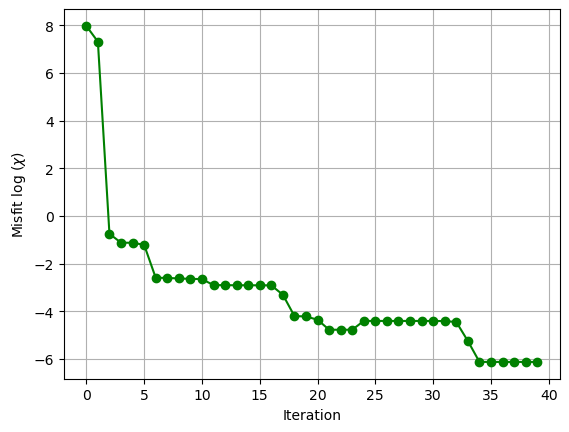

In [ ]:
plt.plot(range(max_ite), np.log(misfit_history[:max_ite]), marker='o', linestyle='-', color='green')
plt.xlabel('Iteration')
plt.ylabel(r'Misfit log $\chi$')

# Set x-axis ticks from 0 to 10
# plt.xticks(range(max_ite))  # 0,1,2,...,10

plt.grid(True)
plt.savefig(Path(IMAGE_DIR_WIN, fr'loss.png'))

plt.show()

In [277]:
np.save(Path(IMAGE_DIR_WIN, fr'model_history_circle_skipping.npy'), m_history)
np.save(Path(IMAGE_DIR_WIN, fr'misfit_history_circle_skipping.npy'), misfit_history)


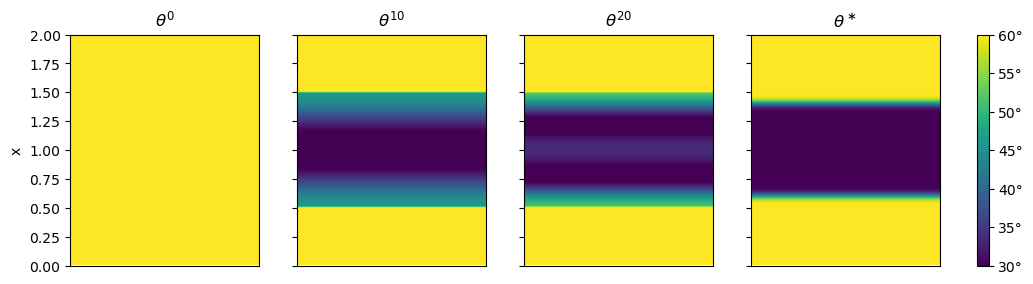

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

def plot_plane_orientation(ax, x, f, title=None, vmin=30, vmax=60):
    """Plot 2D visualization of 1D orientation profile on given Axes."""
    y = np.linspace(0, 1, 100)
    F = np.tile(f, (len(y), 1))
    F_flip = F.T

    im = ax.imshow(
        F_flip,
        extent=[y.min(), y.max(), x.min(), x.max()],
        aspect='auto', origin='lower',
        cmap='viridis', vmin=vmin, vmax=vmax
    )
    ax.set_xticks([])
    if title:
        ax.set_title(title)
    return im

# -----------------------------
# Example: 4 models to visualize
# -----------------------------
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

ids = [0, 10, 20, 'True']  # example iteration IDs
for i, ax in enumerate(axes):
    if ids[i] == 0:
        ax.set_ylabel("x")
        ax.set_ylim(0,2)
    if ids[i] == 'True':
        f = theta_true[m_lim_show[0]:m_lim_show[1]] / np.pi * 180
        title = r"$\theta^\ast$"
    else:
        theta_est = theta_true.copy()
        theta_est[m_lim[0]:m_lim[1]] = m_history[ids[i]]
        f = theta_est[m_lim_show[0]:m_lim_show[1]] / np.pi * 180
        title = rf"$\theta^{({ids[i]})}$"
    im = plot_plane_orientation(ax, z[m_lim_show[0]:m_lim_show[1]]-src_loc, f, title=title)

# Add shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: f'{int(val)}°'))
# cbar.set_label(r'$\theta$ (°)')

# plt.tight_layout()
plt.savefig(Path(IMAGE_DIR_WIN, fr'iterative_model.png'))
plt.show()


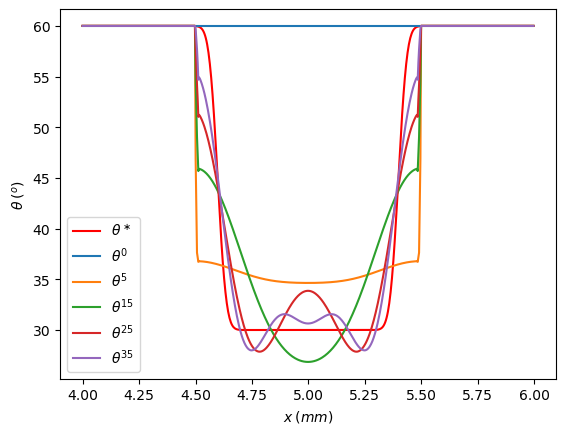

In [28]:
ids = [0, 5, 15, 25, 35]  # example iteration IDs
plt.plot(z[m_lim_show[0]: m_lim_show[1]], theta_true[m_lim_show[0]:m_lim_show[1]] / np.pi * 180,label=fr'$\theta^\ast$', color='red')
color_range = ['red', 'orange', 'gray']
for j, id in enumerate(ids):
    theta_est = theta_true.copy()
    theta_est[m_lim[0]:m_lim[1]] = m_history[id]


    plt.plot(z[m_lim_show[0]: m_lim_show[1]], theta_est[m_lim_show[0]:m_lim_show[1]]/ np.pi * 180, label=fr'$\theta^{({id})}$')


plt.legend([ fr'$m^*$', r'$m^{(j)}$',])
plt.xlabel(r'$x\:(mm)$')
plt.ylabel(r'$\theta\:(^o)$')
plt.legend()
plt.savefig(Path(IMAGE_DIR_WIN, fr'model_is_1d_circle_skipping.png'))

plt.show()



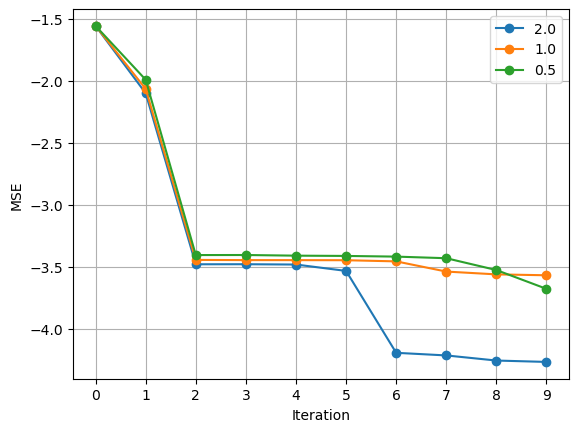

In [ ]:
f_0_ls = [2e3,  4e3,  8e3]

for f_0 in f_0_ls:
    wavelength = 4e3/f_0 
    ratio = wavelength / layer_size
    m_history = np.load(Path(IMAGE_DIR_WIN, fr'model_history_f0_{f_0}.npy'))
    mse = [np.mean((theta_true[m_lim[0]:m_lim[1]] - m_history[id])**2) for id in range(10)]
    plt.plot(range(10), np.log(mse), marker='o', linestyle='-', label=f'{ratio}')
    plt.xlabel('Iteration')
    plt.ylabel(r'MSE')

    # Set x-axis ticks from 0 to 10
    plt.xticks(range(10))  # 0,1,2,...,10

    plt.grid(True)
plt.legend()    
plt.savefig(Path(IMAGE_DIR_WIN, fr'MSE_wavelength_ratio.png'))


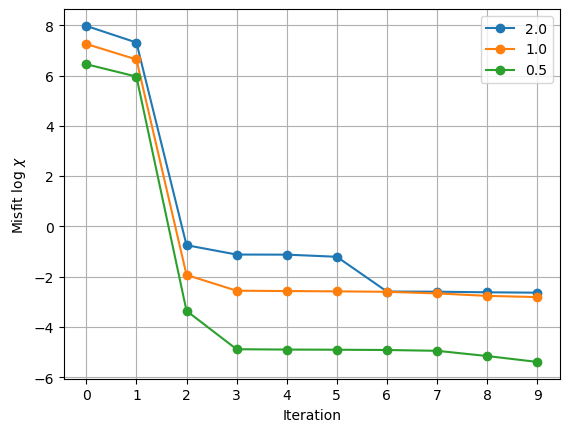

In [ ]:
for f_0 in f_0_ls:
    wavelength = 4e3/f_0 
    ratio = wavelength / layer_size
    misfit_history = np.load(Path(IMAGE_DIR_WIN, fr'misfit_history_f0_{f_0}.npy'))
    plt.plot(range(10), np.log(misfit_history[:10]), marker='o', linestyle='-', label=f'{ratio}')
    plt.xlabel('Iteration')
    plt.ylabel(r'Misfit log $\chi$')

    # Set x-axis ticks from 0 to 10
    plt.xticks(range(10))  # 0,1,2,...,10

    plt.grid(True)
plt.legend()
plt.savefig(Path(IMAGE_DIR_WIN, fr'loss_wavelength_ratio.png'))

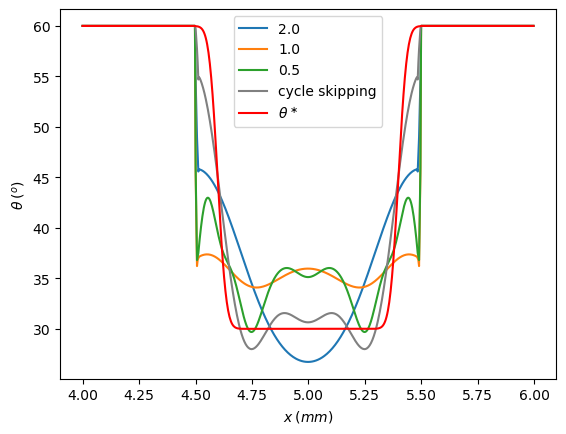

In [37]:
f_0_ls = [2e3,  4e3,  8e3]

for f_0 in f_0_ls:
    wavelength = 4e3/f_0 
    ratio = wavelength / layer_size
    m_history = np.load(Path(IMAGE_DIR_WIN, fr'model_history_f0_{f_0}.npy'))
    theta_est = theta_true.copy()
    theta_est[m_lim[0]:m_lim[1]] = m_history[10]

    plt.plot(z[m_lim_show[0]: m_lim_show[1]], theta_est[m_lim_show[0]:m_lim_show[1]]/ np.pi * 180, label=f'{ratio}')
    
m_history = np.load(Path(IMAGE_DIR_WIN, fr'model_history_circle_skipping.npy'))
theta_est = theta_true.copy()
theta_est[m_lim[0]:m_lim[1]] = m_history[-1]
plt.plot(z[m_lim_show[0]: m_lim_show[1]], theta_est[m_lim_show[0]:m_lim_show[1]]/ np.pi * 180, label=f'cycle skipping', color='gray')


plt.plot(z[m_lim_show[0]: m_lim_show[1]], theta_true[m_lim_show[0]:m_lim_show[1]] / np.pi * 180,label=fr'$\theta^\ast$', color='red')

plt.legend([ fr'$m^*$', r'$m^{(j)}$',])
plt.xlabel(r'$x\:(mm)$')
plt.ylabel(r'$\theta\:(^o)$')
plt.legend()
plt.savefig(Path(IMAGE_DIR_WIN, fr'model_wavelength_ratio_1layer.png'))

plt.show()
